In [1]:
from torchvision.models import resnet50
import torch
from pytorch_grad_cam import GradCAM
from PIL import Image

import sys
sys.path.append("./")
import utils

import numpy as np
import requests
import cv2
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

In [2]:

def get_image_from_url(url):
    """A function that gets a URL of an image, 
    and returns a numpy image and a preprocessed
    torch tensor ready to pass to the model """

    img = np.array(Image.open(requests.get(url, stream=True).raw))
    img = cv2.resize(img, (512, 512))
    rgb_img_float = np.float32(img) / 255
    input_tensor = preprocess_image(rgb_img_float,
                                   mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
    return img, rgb_img_float, input_tensor

def get_image_from_path(path):
    """A function that gets a URL of an image, 
    and returns a numpy image and a preprocessed
    torch tensor ready to pass to the model """

    img = np.array(Image.open(fp=path).convert("RGB"))
    img = cv2.resize(img, (224, 224))
    rgb_img_float = np.float32(img) / 255
    input_tensor = preprocess_image(rgb_img_float,
                                   mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
    return img, rgb_img_float, input_tensor


In [3]:
class ClassifierOutputTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):
        if len(model_output.shape) == 1:
            return model_output[self.category]
        return model_output[:, self.category]
    
def get_gram_composed_img(model, target_layers, targets):
    with GradCAM(model=model,
                 target_layers=target_layers,
                 use_cuda=True) as cam:
        tmp = cam(input_tensor=input_tensor,
                            targets=targets)[0, :]
    composed_img = show_cam_on_image(image_float, tmp, use_rgb=True)
    return composed_img

In [73]:
# img, image_float, input_tensor = get_image_from_path("/home/le/datasets/MIDOG2022/BIMCV/crop/sub-S03073_ses-E06266_run-1_bp-chest_vp-ap_cr427.png")
# img, image_float, input_tensor = get_image_from_path("/home/le/datasets/MIDOG2022/BIMCV/crop/sub-S03141_ses-E06865_run-1_bp-chest_vp-pa_dx822.png")
# img, image_float, input_tensor = get_image_from_path("/home/le/datasets/MIDOG2022/BIMCV/crop/sub-S03216_ses-E06363_run-1_bp-chest_vp-ap_dx395.png")
img, image_float, input_tensor = get_image_from_path("/home/le/datasets/MIDOG2022/processed_pngs/244_13765.png")
img, image_float, input_tensor = get_image_from_path("/home/le/datasets/MIDOG2022/processed_pngs/212_8866.png")
img, image_float, input_tensor = get_image_from_path("/home/le/datasets/MIDOG2022/processed_pngs/103_2891.png")

ds = "MIDOG"



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
target_label = 1

model = torch.load(f'models/{ds}/ttl.pt').module.to(device)
target_layers = [list(list(model.children())[-2].children())[-1]]
print(target_layers)
targets = [ClassifierOutputTarget(target_label)]
image_ttl = get_gram_composed_img(model, target_layers, targets)


model = torch.load(f'models/{ds}/ftl.pt').module.to(device)
target_layers = [list(list(model.children())[-2].children())[-1]]
print(target_layers)
targets = [ClassifierOutputTarget(target_label)]
image_ftl = get_gram_composed_img(model, target_layers, targets)



model = torch.load(f'models/{ds}/lwft.pt').module.to(device)
target_layers = [list(list(model.children())[-2].children())[-2]]
print(target_layers)
targets = [ClassifierOutputTarget(target_label)]
image_lwft = get_gram_composed_img(model, target_layers, targets)



model = torch.load(f'models/{ds}/tf.pt').module.to(device)
target_layers = [model.layer4[-1]]
print(target_layers)
targets = [ClassifierOutputTarget(target_label)]
image_tf = get_gram_composed_img(model, target_layers, targets)

[Bottleneck(
  (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)]
[Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn

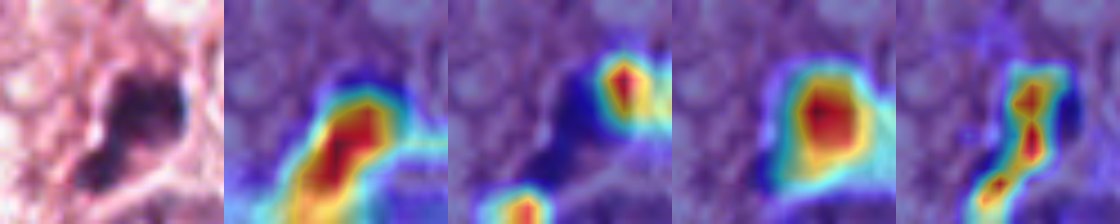

In [74]:
Image.fromarray(np.hstack((img, image_ftl, image_lwft, image_tf, image_ttl)))